In [1]:
include("../src.jl")

itproot

# Метод Риддерса

Метод Риддерса {cite}`ridders1979` основывается на линеаризации исходной функции с последующим применением regula falsi к новой, модифицированной функции.

## Вывод метода

Пусть мы ищем приближение корня уравнения $f(x) = 0$ на отрезке $[x_0, x_2]$, при этом $f(x_0)f(x_2) < 0$. Заведём новую функцию $g(x)$

```{math}
g(x) = f(x) e^{mx},
```

таким образом, что точки $(x_0, g(x_0))$, $(x_2, g(x_2))$ и $(x_1, g(x_1))$ (где $x_1 = (x_0 + x_2)/2$) лежат на одной прямой:

```{math}
g(x_1) = \frac{g(x_0) + g(x_2)}{2} \iff g(x_0) - 2 g(x_1) + g(x_2) = 0.
```

```{figure} ridders_notation.png
---
height: 480px
---
К методу Риддерса.
```

Подставим сюда определение $g(x)$ и получим уравнение

```{math}
f(x_0)e^{mx_0} - 2 f(x_1) e^{mx_1} + f(x_2)e^{mx_2} = 0.
```

Домножим на $e^{-mx_0}$ и получим квадратное уравнение на $e^{md}$

```{math}
f(x_0) - 2 f(x_1) e^{md} + f(x_2) e^{2md} = 0,\quad d = x_2 - x_1 = x_1 - x_0.
```

Решая его, получим

```{math}
e^{md} = \frac{f(x_1) - \sign(f(x_0))\sqrt{W}}{f(x_2)}, \quad W = f(x_1)^2 - f(x_0)f(x_2).
```

Таким образом, функция $g(x) = f(x) e^{md}$ задана. Теперь сделаем regula falsi шаг через точки $(x_1, g(x_1))$ и $(x_2, g(x_2))$, получив $x_3$

```{math}
x_3 = \frac{x_1 g(x_2) - x_2 g(x_1)}{g(x_2) - g(x_1)}.
```

Или

```{math}
x_3 = x_1 + \sign(f(x_0))\frac{f(x_1)d}{\sqrt{W}}.
```

После чего обновим интервал так, чтобы $f(x_3) f(x_i) < 0$, $i=0,1,2$.

Метод Риддерса обладает квадратичной сходимостью, но требует 2 вычисления функции на итерации (в точках $x_1$ и $x_3$), поэтому его скорость сходимости на вычисление равняется $\sqrt{2}$ и можно говорить о *сверхлинейной сходимости на вычисление функции*.

## Реализация

```{proof:function} ridders

**Метод Риддерса**

:::julia
"""
    ridders(f, x₁, x₂[; maxiter=25, xtol=eps(), ftol=eps()])

Решает уравнение `f`(x) = 0 методом Риддерса на отрезке [`x₁`, `x₂`].
Если отрезок не уменьшится до `xtol`, или функция не уменьшится до `ftol`
за ≤ `maxiter` итераций, выдаёт ошибку.
"""
function ridders(f, x₁, x₂; maxiter=25, xtol=eps(), ftol=eps())
    if x₁ > x₂; x₁, x₂ = x₂, x₁; end
    y₁, y₂ = f.((x₁, x₂))
    y₁ * y₂ > 0 && error("Функция должна иметь разные знаки в концах отрезка")
    y₁ == 0 && return x₁
    y₂ == 0 && return x₂
    
    for i in 1:maxiter
        xmid = (x₁ + x₂) / 2
        ymid = f(xmid)
        xnew = xmid + (xmid - x₁) * sign(y₁) * ymid / sqrt(ymid^2 - y₁*y₂)
        ynew = f(xnew)

        ynew == 0 && return xnew
        
        if sign(ynew) == sign(y₂)
            x₂, y₂ = xnew, ynew
        elseif sign(ynew) == sign(y₁)
            x₁, y₁ = xnew, ynew
        end
        if abs(ynew) < ftol || abs(x₁ - x₂) < xtol
            return xnew
        end
    end
    error("Число итераций превышено.")
end
:::
```

```{proof:demo} Метод Риддерса
```
```{raw} html
<div class="demo">
```

Рассмотрим работу метода Риддерса на функции $f(x) = (\tan{x})^{\tan{x}} - 10^3$ из оригинальной работы {cite}`ridders1979`.



В качестве начального интервала возьмём $[0, 1.5]$. Функция принимает в концах отрезка значения, отличающиеся на 13 порядков!

In [2]:
f = (x) -> tan(x)^tan(x) - 1e3
@show f(0) f(1.5);

f(0) = -999.0
f(1.5) = 1.607822215747618e16


Ниже на верхнем графике показано масштаб функции на отрезке. А на втором графике найденный методом Риддерса корень. Метод справился за 8 итераций с точностью локализации корня `xtol = 1e-6`.

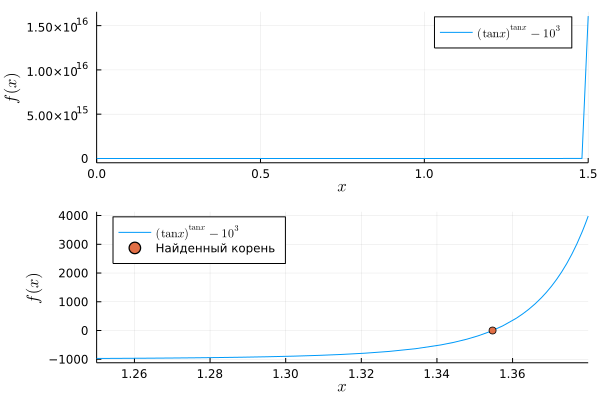

In [3]:
root = ridders(f, 0, 1.5; xtol=1e-6, maxiter=8)
plt = plot(; layout=(2,1), xlabel=L"x", ylabel=L"f(x)")
plot!(f; xlim=(0, 1.5), subplot=1, label=L"(\tan x)^{\tan x} - 10^3")

plot!(f; xlim=(1.25, 1.38), subplot=2, label=L"(\tan x)^{\tan x} - 10^3")
scatter!([root], [f(root)]; subplot=2, label="Найденный корень", leg=:topleft)

Сравним с методом regula falsi. Для этого выставим для методов одинаковые `ftol`.

In [4]:
regulafalsi(f, 0, 1.5; ftol=1e-6, maxiter=1000);

LoadError: Число итераций превышено.

In [5]:
@show ridders(f, 0, 1.5; ftol=1e-6, maxiter=8);

ridders(f, 0, 1.5; ftol = 1.0e-6, maxiter = 8) = 1.3547104419557727


Метод Риддерса обнаружил корень на отрезке за 8 итераций, тогда как regula falsi не справился за 1000.

```{raw} html
</div>
```